In [2]:
import pandas as pd
import numpy as np
import psycopg2
import pandas.io.sql as psql
import config
import random
import datetime as dt
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImblearnPipeline
from sklearn.datasets import make_classification
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency

In [3]:
# Call variable in config.py
dbname = config.dbname
user = '' # Change to your userid
password = '' # Change to your password
host = config.host
port = config.port

In [4]:
connection = psycopg2.connect(
    dbname=dbname,
    user=user,
    password=password,
    host=host,
    port=port
)

In [5]:
# Set seed
random.seed(42)

In [6]:
# TRNSACT
cursor = connection.cursor()
cursor.execute('''SELECT "SKU", "STORE", "TRANNUM", "SALEDATE", "QUANTITY", "STYPE", "ORGPRICE", "SPRICE", "AMT" FROM group_3.trnsact TABLESAMPLE SYSTEM(10);''')
result = cursor.fetchall()
trnsact = pd.DataFrame(result)

column_names = [desc[0] for desc in cursor.description]
trnsact.columns = column_names
trnsact

,SKU,STORE,TRANNUM,SALEDATE,QUANTITY,STYPE,ORGPRICE,SPRICE,AMT
0,268,6503,3900,2005-03-06,1,P,36.0,24.12,24.12
1,268,6703,12100,2005-02-26,1,P,36.0,12.06,12.06
2,268,6803,3500,2005-03-21,1,P,36.0,12.06,12.06
3,268,7007,7000,2004-09-09,1,P,29.0,29.0,29.0
4,268,7103,300,2004-09-13,1,P,36.0,36.0,36.0
...,...,...,...,...,...,...,...,...,...
11252214,9999950,9303,7200,2005-08-15,1,P,14.0,14.0,14.0
11252215,9999950,9303,8300,2004-08-14,1,P,13.5,13.5,13.5
11252216,9999950,9304,200,2005-08-15,1,P,14.0,14.0,14.0
11252217,9999950,9304,300,2005-02-09,1,P,13.5,13.5,13.5


In [7]:
trnsact_copy = trnsact.copy()

In [8]:
# SKUINFO
cursor.execute('''SELECT "SKU", "DEPT", "STYLE", "COLOR", "SIZE", "BRAND" FROM group_3.skuinfo;''')
result = cursor.fetchall()
skuinfo = pd.DataFrame(result)

column_names = [desc[0] for desc in cursor.description]
skuinfo.columns = column_names
skuinfo

,SKU,DEPT,STYLE,COLOR,SIZE,BRAND
0,3,6505,00 F55KT2,WHISPERWHITE,P8EA,TURNBURY
1,4,8101,22 615CZ4,SPEARMI,S,C A SPOR
2,5,7307,7LBS 245-01,34 SILVER,KING,BEAU IDE
3,8,3404,622 F05H84,MORNING MI,2T,HARTSTRI
4,15,2301,126 MDU461,255CAMEL,12,JONES/LA
...,...,...,...,...,...,...
1556025,9999973,3103,702 S3JAYV,STONE,4,POLO JEA
1556026,9999974,9801,G50171,NAVY MULTI,10,GABAR IN
1556027,9999991,2301,026 MDU201,618RED ROSE,8,JONES/LA
1556028,9999992,1202,14 F52UN1,PALE JADE,L,CABERNET


In [9]:
# SKSTINFO
cursor.execute('''SELECT * FROM group_3.skstinfo;''')
result = cursor.fetchall()
skstinfo = pd.DataFrame(result)

column_names = [desc[0] for desc in cursor.description]
skstinfo.columns = column_names
skstinfo

,SKU,STORE,COST,RETAIL,UNCLEAR
0,8508974,8402,181.0,595.0,0
1,8508974,9103,181.0,595.0,0
2,8508974,9304,181.0,595.0,0
3,8508980,707,6.8,8.0,0
4,8508980,1502,6.8,4.38,0
...,...,...,...,...,...
39100546,8508974,2109,181.0,595.0,0
39100547,8508974,2203,181.0,595.0,0
39100548,8508974,6402,181.0,595.0,0
39100549,8508974,6503,181.0,595.0,0


In [10]:
cursor.close()
connection.close()

In [11]:
# Drop the last unclear column
skstinfo.drop(columns=["UNCLEAR"],inplace=True)
skstinfo

,SKU,STORE,COST,RETAIL
0,8508974,8402,181.0,595.0
1,8508974,9103,181.0,595.0
2,8508974,9304,181.0,595.0
3,8508980,707,6.8,8.0
4,8508980,1502,6.8,4.38
...,...,...,...,...
39100546,8508974,2109,181.0,595.0
39100547,8508974,2203,181.0,595.0
39100548,8508974,6402,181.0,595.0
39100549,8508974,6503,181.0,595.0


In [12]:
# Check missing values
trnsact.isna().sum()

SKU         0
STORE       0
TRANNUM     0
SALEDATE    0
QUANTITY    0
STYPE       0
ORGPRICE    0
SPRICE      0
AMT         0
dtype: int64

In [13]:
skstinfo.isna().sum()

SKU       0
STORE     0
COST      0
RETAIL    0
dtype: int64

In [14]:
skuinfo.isna().sum()

SKU      0
DEPT     0
STYLE    0
COLOR    0
SIZE     0
BRAND    0
dtype: int64

In [15]:
trnsact.dtypes

SKU          int64
STORE        int64
TRANNUM      int64
SALEDATE    object
QUANTITY     int64
STYPE       object
ORGPRICE    object
SPRICE      object
AMT         object
dtype: object

In [16]:
trnsact_copy['SALEDATE'] = pd.to_datetime(trnsact_copy['SALEDATE'])
trnsact_copy['ORGPRICE'] = pd.to_numeric(trnsact_copy['ORGPRICE'], errors='coerce')
trnsact_copy['SPRICE'] = pd.to_numeric(trnsact_copy['SPRICE'], errors='coerce')
trnsact_copy['AMT'] = pd.to_numeric(trnsact_copy['AMT'], errors='coerce')

# Drop the rows where trnsact['ORGPRICE'] == 0
trnsact_copy = trnsact_copy[trnsact_copy['ORGPRICE'] != 0]

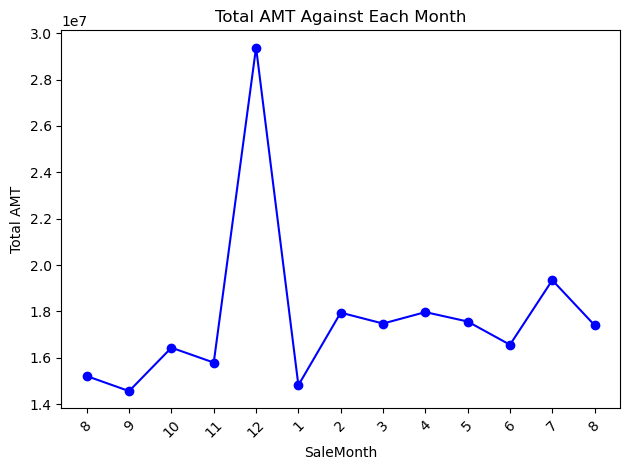

In [17]:
# Extract the year and month from the transaction records
trnsact_copy['SaleYear'] = trnsact_copy['SALEDATE'].dt.year
trnsact_copy['SaleMonth'] = trnsact_copy['SALEDATE'].dt.month

# Transfer the amt of return transaction into negative, we assume that there is a corresponding purchase transaction record before return
# Therefore, this two records can cancel each other out and have no effect on total sales amount. Treat the total amt as income charge
trnsact_copy.loc[trnsact_copy['STYPE'] == 'R', 'AMT'] = -trnsact_copy.loc[trnsact_copy['STYPE'] == 'R', 'AMT']

# Total sales amount agains each month
monthly_sales = trnsact_copy.groupby(['SaleYear', 'SaleMonth'])['AMT'].sum().reset_index()

plt.plot(monthly_sales.index, monthly_sales['AMT'], marker='o', linestyle='-', color='b')
plt.xlabel('SaleMonth')
plt.ylabel('Total AMT')
plt.title('Total AMT Against Each Month')
plt.xticks(monthly_sales.index, monthly_sales['SaleMonth'], rotation=45)
plt.tight_layout()
plt.show()

In [18]:
# Total discount items count for each month
monthlydiscount = trnsact_copy[trnsact_copy['ORGPRICE'] != trnsact_copy['SPRICE']].groupby(['SaleYear', 'SaleMonth']).SKU.count()
monthlydiscount = monthlydiscount.reset_index().rename(columns={'SKU': 'discount_item_num'})
# Total items count for each month
monthlysales = trnsact_copy.groupby(['SaleYear', 'SaleMonth']).SKU.count()
monthlysales = monthlysales.reset_index().rename(columns={'SKU': 'total_item_num'})

# Discount percentage
discount_percentage = pd.merge(monthlydiscount, monthlysales, on = ['SaleYear', 'SaleMonth'], how = 'inner')
discount_percentage['percentage'] = discount_percentage['discount_item_num'] / discount_percentage['total_item_num']
discount_percentage

,SaleYear,SaleMonth,discount_item_num,total_item_num,percentage
0,2004,8,409244,770358,0.531239
1,2004,9,500144,834146,0.599588
2,2004,10,271798,776954,0.349825
3,2004,11,258436,648570,0.398470
4,2004,12,579743,1246636,0.465046
5,2005,1,528277,822278,0.642455
6,2005,2,746647,1068305,0.698908
7,2005,3,395027,836506,0.472235
8,2005,4,267180,775910,0.344344
9,2005,5,268159,710194,0.377586


In [19]:
# Daily total income amount of transaction charge
df_date = pd.pivot_table(trnsact_copy, values = ["AMT"], index = ['SALEDATE'], aggfunc = {'AMT': 'sum'}).reset_index()
df_date

,SALEDATE,AMT
0,2004-08-01,381666.13
1,2004-08-02,345650.13
2,2004-08-03,420596.00
3,2004-08-04,427993.49
4,2004-08-05,483289.25
...,...,...
384,2005-08-23,434300.88
385,2005-08-24,728948.22
386,2005-08-25,662588.14
387,2005-08-26,777359.42


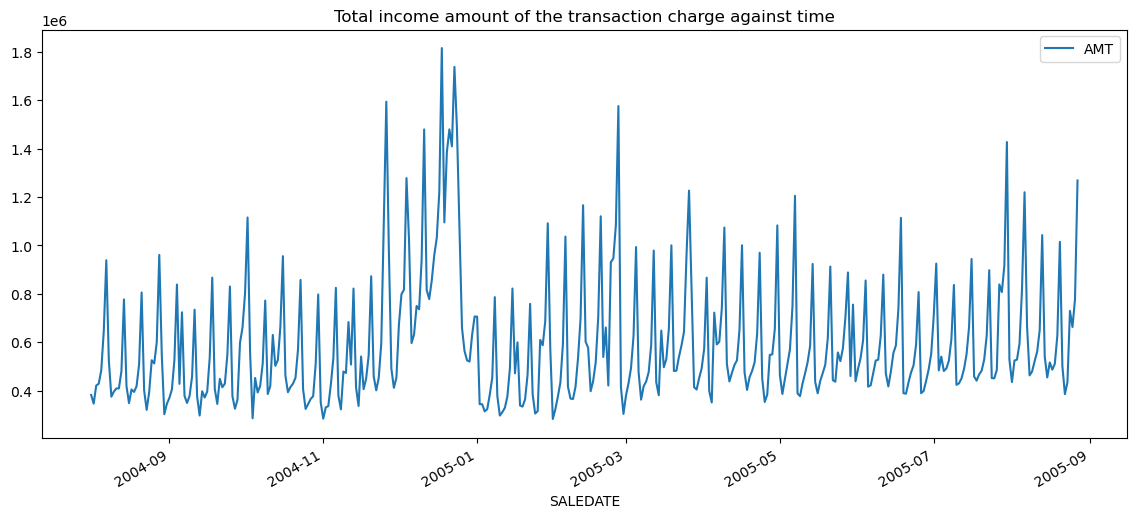

In [20]:
# Plot daily total income amount of transaction charge
df_date.plot.line(x = "SALEDATE", y = "AMT", figsize = (14,6), title = "Total income amount of the transaction charge against time");

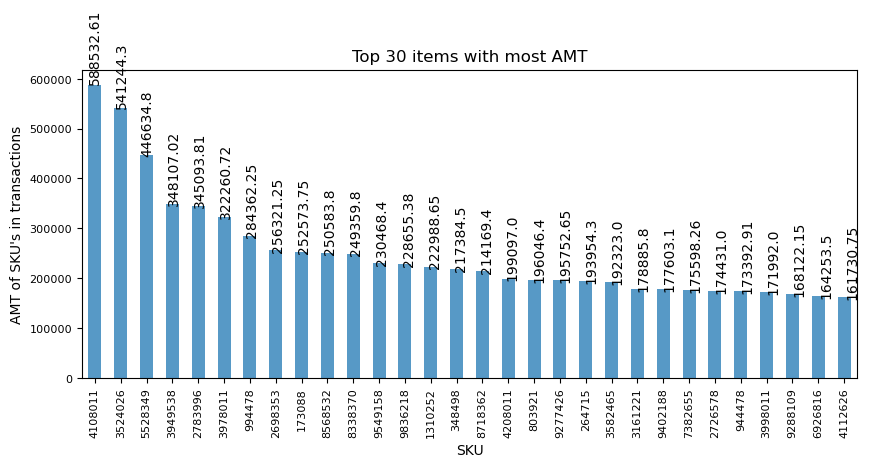

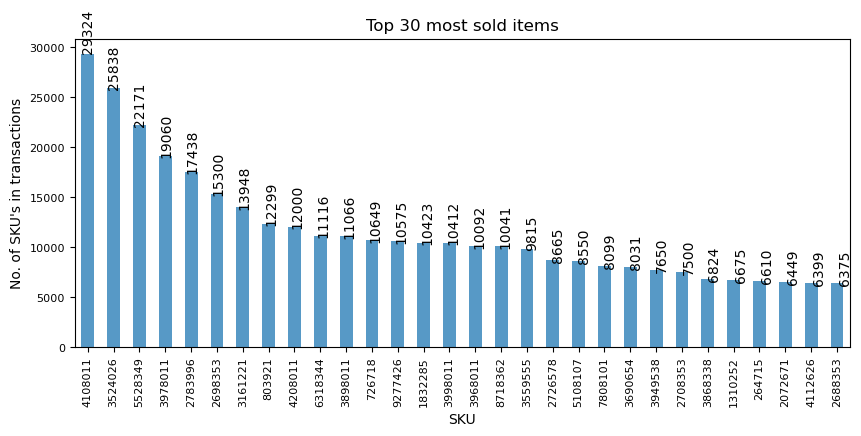

In [21]:
# Top 30 items with the most AMT
SKU_transactions = trnsact_copy.groupby("SKU")['AMT'].sum().sort_values(ascending = False).head(30)

ax = SKU_transactions.plot(kind = 'bar', rot = 90, fontsize = 8, alpha = 0.75, figsize = (10,4))
plt.title("Top 30 items with most AMT")
plt.xlabel("SKU")
plt.ylabel("AMT of SKU's in transactions")

for i in ax.patches:
    ax.annotate(str(i.get_height()), 
               (i.get_x()*1.01, i.get_height()*1.01),
               rotation = 90)
plt.show()

# Top 30 most sold items
SKU_count = trnsact_copy.SKU.value_counts().head(30)

ax = SKU_count.plot(kind = 'bar', rot = 90, fontsize = 8, alpha = 0.75, figsize = (10,4))
plt.title("Top 30 most sold items")
plt.xlabel("SKU")
plt.ylabel("No. of SKU's in transactions")

for i in ax.patches:
    ax.annotate(str(i.get_height()), 
               (i.get_x()*1.01, i.get_height()*1.01),
               rotation = 90)
plt.show()

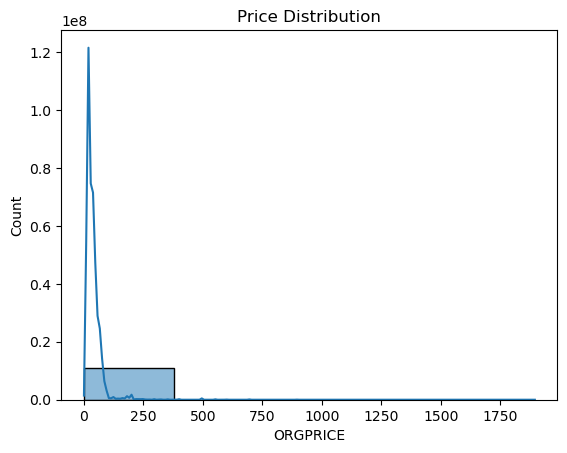

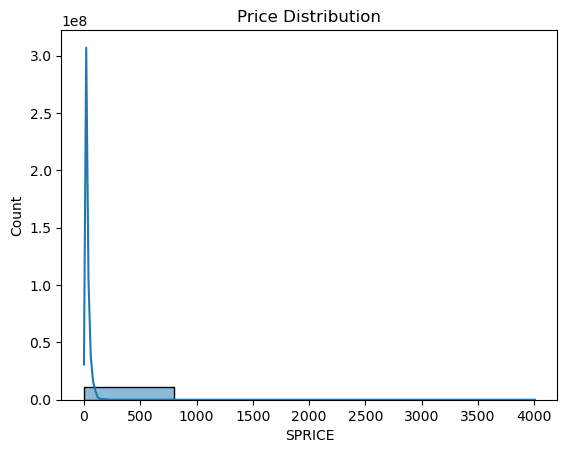

In [22]:
sns.histplot(trnsact_copy['ORGPRICE'], bins=5, kde=True)
plt.title('Price Distribution')
plt.show()
sns.histplot(trnsact_copy['SPRICE'], bins=5, kde=True)
plt.title('Price Distribution')
plt.show()

In [23]:
skstinfo.dtypes

SKU        int64
STORE      int64
COST      object
RETAIL    object
dtype: object

In [24]:
skstinfo['RETAIL'] = pd.to_numeric(skstinfo['RETAIL'])
skstinfo['COST'] = pd.to_numeric(skstinfo['COST'])

In [25]:
# Check if retail price is equal to orgprice
merged_table = pd.merge(skstinfo, trnsact_copy, on = ['SKU', 'STORE'], how = 'inner')
merged_table = merged_table[merged_table['RETAIL'] == merged_table['ORGPRICE']]

# Calculate the revenue for the transactions
merged_table['Revenue'] = (merged_table['SPRICE'] - merged_table['COST']) * merged_table['QUANTITY']
merged_table.loc[merged_table['STYPE'] == 'R', 'Revenue'] = merged_table.loc[merged_table['STYPE'] == 'R', 'Revenue']

# Daily total revenue
df_date_revenue = merged_table.groupby('SALEDATE')['Revenue'].sum().reset_index()

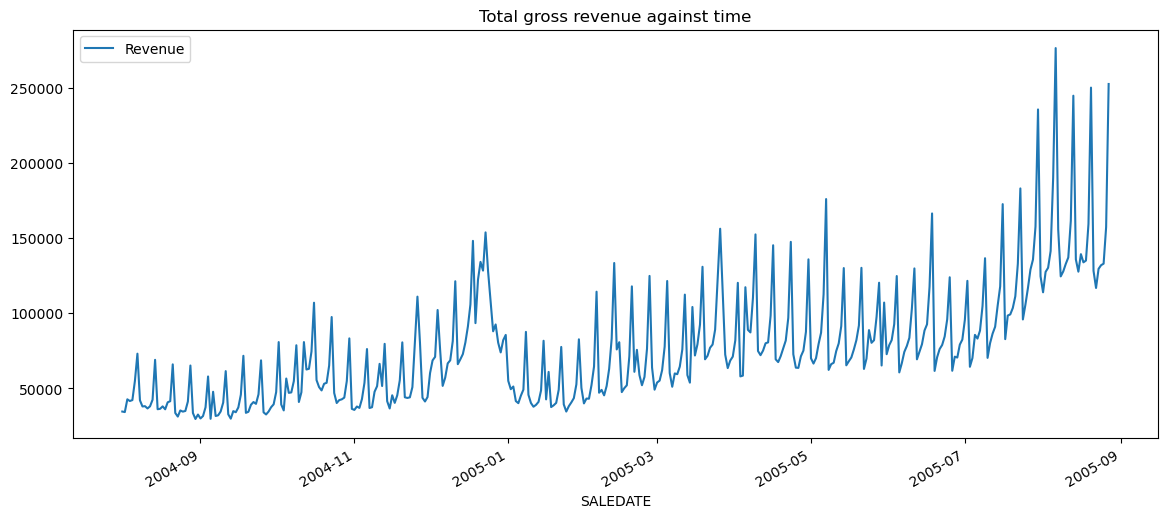

In [26]:
df_date_revenue.plot.line(x = "SALEDATE", y = "Revenue", figsize = (14,6), title = "Total gross revenue against time");

## Store

In [27]:
df_store = pd.pivot_table(trnsact,
                          values = ['SKU', "QUANTITY", "SPRICE", "AMT"],
                          index = ['STORE'], 
                          aggfunc = {'SKU':'count',
                                     'QUANTITY': 'sum',
                                     'AMT':[np.mean, 'sum']})

df_store

AMT             QUANTITY    SKU
            mean         sum      sum  count
STORE                                       
102    30.892803  1542879.25    49943  49943
103    28.062801  1263639.85    45029  45029
107    28.122090  1926166.29    68493  68493
202    24.243397   717168.17    29582  29582
203    26.847282  1154889.52    43017  43017
...          ...         ...      ...    ...
9709   21.052574   494167.08    23473  23473
9804   24.534989   561654.96    22892  22892
9806   35.089370  1410803.23    40206  40206
9906    4.000000         4.0        1      1
9909   21.282425   465169.96    21857  21857

[330 rows x 4 columns]

## ML Question: 
#### Type of Transaction Prediction: Use historical sales data to build a model to predict if the product will be returned (R) or not.

* Join STRNSACT, SKSTINFO, SKUINFO for feature selection; Further Data Cleaning

In [28]:
trnsact['SALEDATE'] = pd.to_datetime(trnsact['SALEDATE'])
trnsact['ORGPRICE'] = pd.to_numeric(trnsact['ORGPRICE'], errors='coerce')
trnsact['SPRICE'] = pd.to_numeric(trnsact['SPRICE'], errors='coerce')
trnsact['AMT'] = pd.to_numeric(trnsact['AMT'], errors='coerce')

In [29]:
# Merge TRNSACT, SKSTINFO, SKUINFO
merged_df = pd.merge(trnsact, skstinfo, on=['SKU', 'STORE'], how='left')
merged_df = pd.merge(merged_df, skuinfo, on=['SKU'], how='left')

# Show column data types
merged_df.dtypes

SKU                  int64
STORE                int64
TRANNUM              int64
SALEDATE    datetime64[ns]
QUANTITY             int64
STYPE               object
ORGPRICE           float64
SPRICE             float64
AMT                float64
COST               float64
RETAIL             float64
DEPT                 int64
STYLE               object
COLOR               object
SIZE                object
BRAND               object
dtype: object

In [30]:
# Update data types
merged_df['SKU'] = merged_df['SKU'].astype(str)
merged_df['STORE'] = merged_df['STORE'].astype(str)
merged_df['DEPT'] = merged_df['DEPT'].astype(str)
merged_df['ORGPRICE'] = merged_df['ORGPRICE'].astype(float)
merged_df['SPRICE'] = merged_df['SPRICE'].astype(float)
merged_df['AMT'] = merged_df['AMT'].astype(float)
merged_df['COST'] = merged_df['COST'].astype(float)
merged_df['RETAIL'] = merged_df['RETAIL'].astype(float)
# Take saledate into datatime and split as specific month and year
merged_df['SALEDATE'] = pd.to_datetime(merged_df['SALEDATE'])
merged_df['year'] = merged_df['SALEDATE'].dt.year.astype('category')
merged_df['month'] = merged_df['SALEDATE'].dt.month.astype('category')
merged_df['day_of_week'] = merged_df['SALEDATE'].dt.dayofweek.astype('category')
merged_df['day_of_month'] = merged_df['SALEDATE'].dt.day.astype('category')
merged_df['quarter'] = merged_df['SALEDATE'].dt.quarter.astype('category')
# Check data types
merged_df.dtypes

SKU                     object
STORE                   object
TRANNUM                  int64
SALEDATE        datetime64[ns]
QUANTITY                 int64
STYPE                   object
ORGPRICE               float64
SPRICE                 float64
AMT                    float64
COST                   float64
RETAIL                 float64
DEPT                    object
STYLE                   object
COLOR                   object
SIZE                    object
BRAND                   object
year                  category
month                 category
day_of_week           category
day_of_month          category
quarter               category
dtype: object

In [31]:
# Checking NA value in COST and RETAIL
merged_df[['COST', 'RETAIL']].isna().sum()

COST      4936370
RETAIL    4936370
dtype: int64

In [32]:
# Drop rows that with NA on COST and RETAIL
merged_df.dropna(subset=['COST', 'RETAIL'], inplace=True)
merged_df.head()

,SKU,STORE,TRANNUM,SALEDATE,QUANTITY,STYPE,ORGPRICE,SPRICE,AMT,COST,...,DEPT,STYLE,COLOR,SIZE,BRAND,year,month,day_of_week,day_of_month,quarter
0,268,6503,3900,2005-03-06,1,P,36.0,24.12,24.12,15.75,...,8101,120198311332,BROWN,14,JERELL /,2005,3,6,6,1
1,268,6703,12100,2005-02-26,1,P,36.0,12.06,12.06,15.75,...,8101,120198311332,BROWN,14,JERELL /,2005,2,5,26,1
7,268,7303,5200,2005-02-25,1,P,36.0,12.06,12.06,15.75,...,8101,120198311332,BROWN,14,JERELL /,2005,2,4,25,1
20,268,7807,300,2004-12-03,1,P,29.0,29.00,29.00,15.75,...,8101,120198311332,BROWN,14,JERELL /,2004,12,4,3,4
21,268,7807,900,2004-12-24,1,P,29.0,29.00,29.00,15.75,...,8101,120198311332,BROWN,14,JERELL /,2004,12,4,24,4


In [33]:
# Featuring Engineering

# RETAIL means the price that a customer will pay when purchasing a product at a retail store
# but don't know between RETAIL AND SPRICE

# Create markup percentage columns based on SPRICE and COST
# the cost price too low means item sucks, and it might increase rate to be returned?
merged_df['Markup_Percentage'] = (merged_df['SPRICE'] - merged_df['COST']) / merged_df['COST']

# See total number of transactions per SKU, STORE
# maybe more merchandise defects exist in smaller stores?
# Since 'AMT' represents the total amount of the transaction, counting the occurrences essentially calculates the number of transactions for each 'SKU' and 'STORE' combination.
merged_df['Num_Transactions'] = merged_df.groupby(['SKU', 'STORE'])['AMT'].transform('count')

In [34]:
merged_df.dropna(subset=['Markup_Percentage'], inplace=True)

In [35]:
# total[total['Markup_Percentage']==np.inf]
finite_value = 1e10
merged_df.replace([np.inf, -np.inf], finite_value, inplace=True)

In [36]:
# The number of unique values in each column
merged_df.nunique()

SKU                  107342
STORE                   325
TRANNUM                2188
SALEDATE                389
QUANTITY                  2
STYPE                     2
ORGPRICE                641
SPRICE                 5017
AMT                    5017
COST                   3198
RETAIL                 1376
DEPT                     60
STYLE                 57335
COLOR                 17561
SIZE                   2363
BRAND                  1096
year                      2
month                    12
day_of_week               7
day_of_month             31
quarter                   4
Markup_Percentage     73453
Num_Transactions        251
dtype: int64

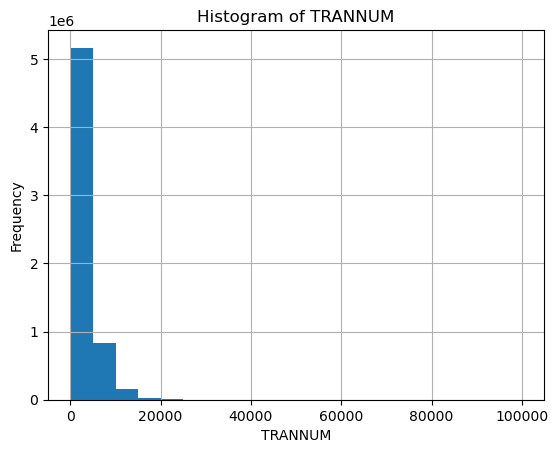

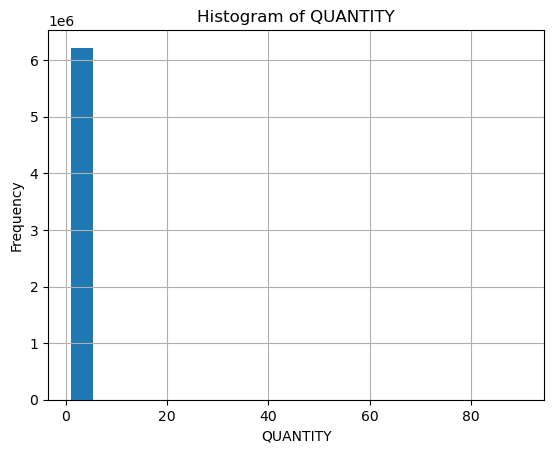

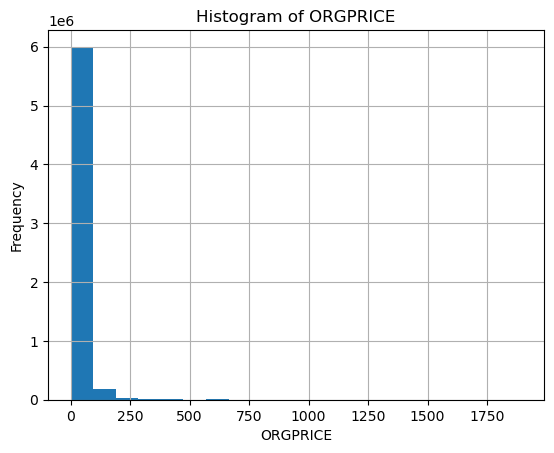

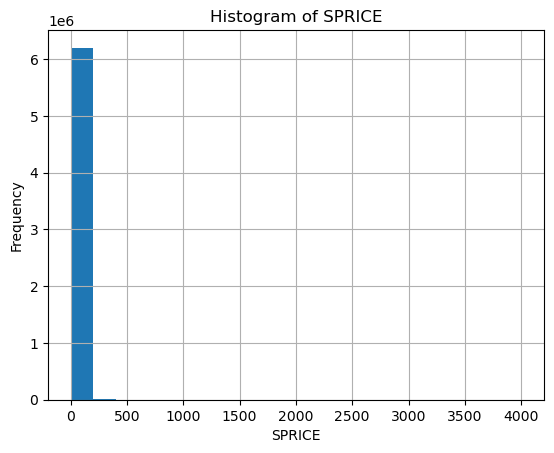

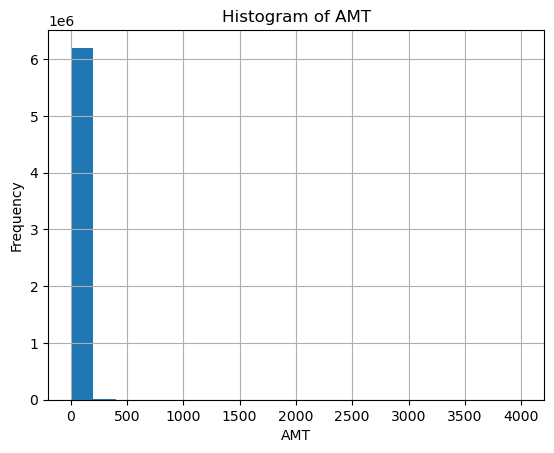

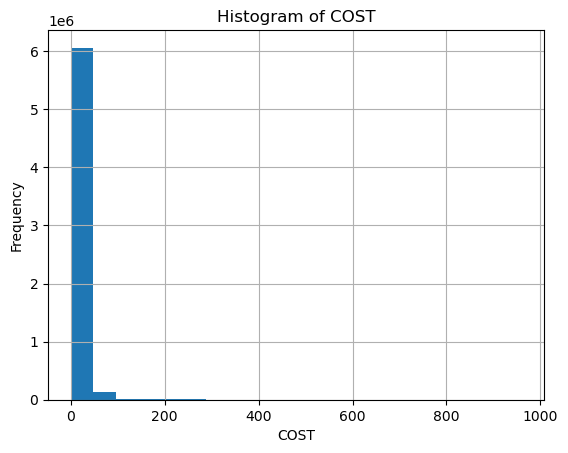

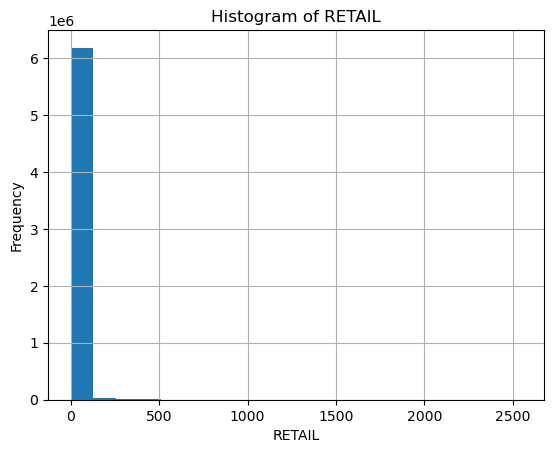

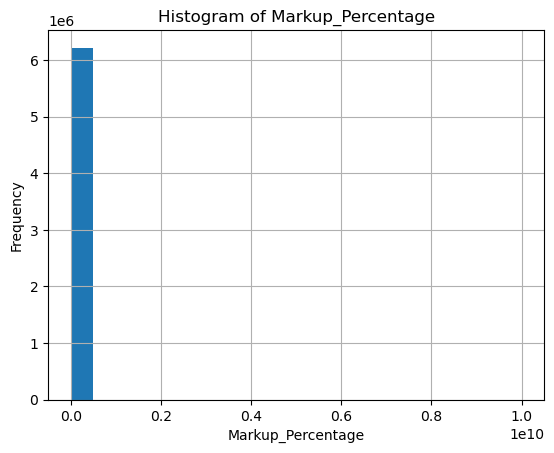

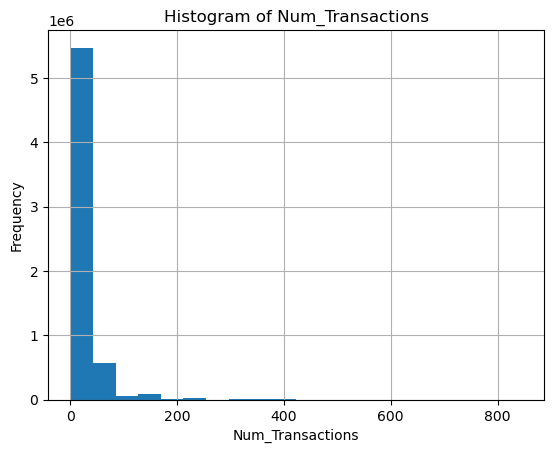

In [37]:
# Evaludate the distribution of each numerical feature
numerical_df = merged_df.select_dtypes(include=['float64', 'int64'])

# Plot a histogram for each numerical feature
for column in numerical_df.columns:
    plt.figure()  # Create a new figure for each histogram
    numerical_df[column].hist(bins=20)  # You can specify the number of bins
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()
# We noticed most of them are right-skewed, we tried log transformation

/Users/tianjiayue/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


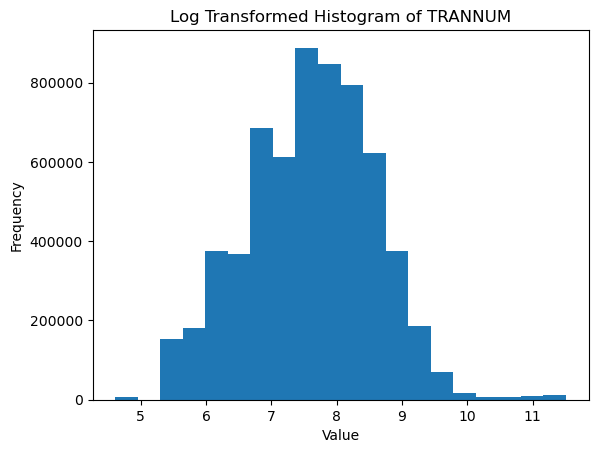

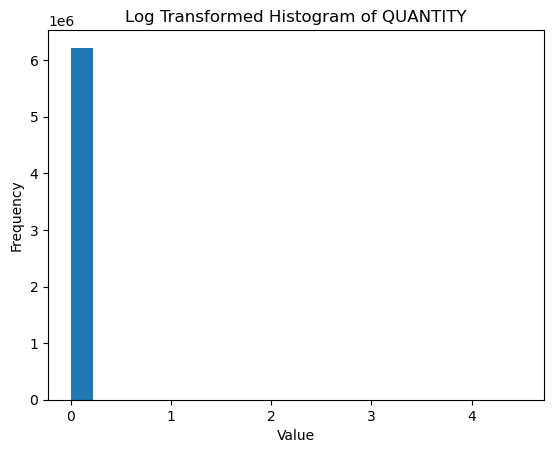

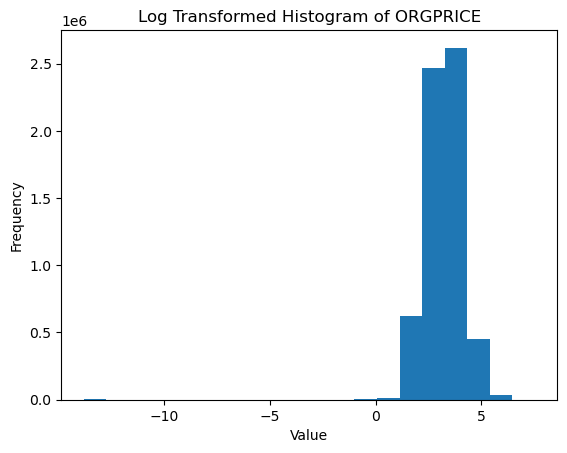

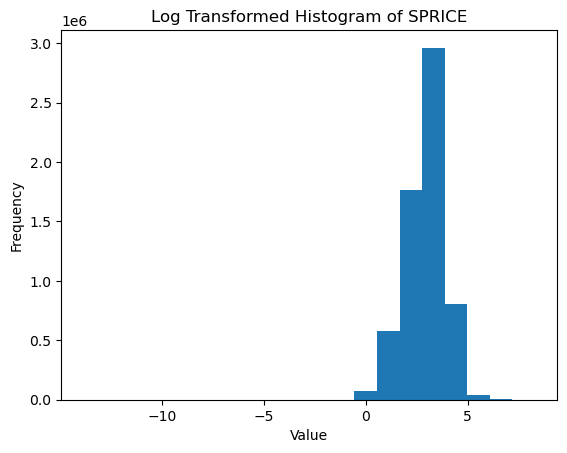

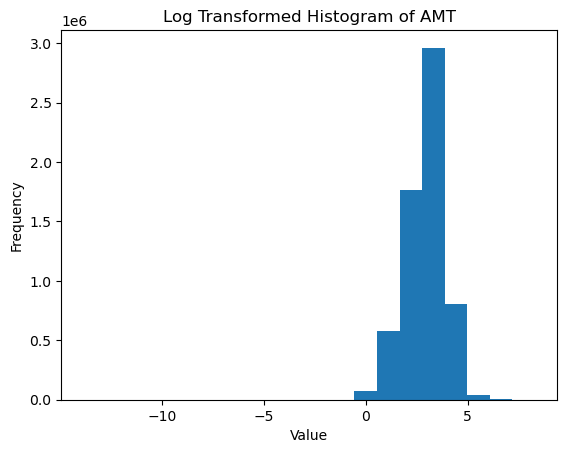

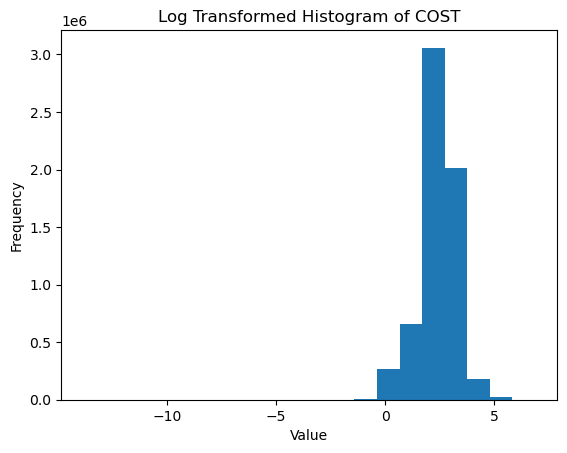

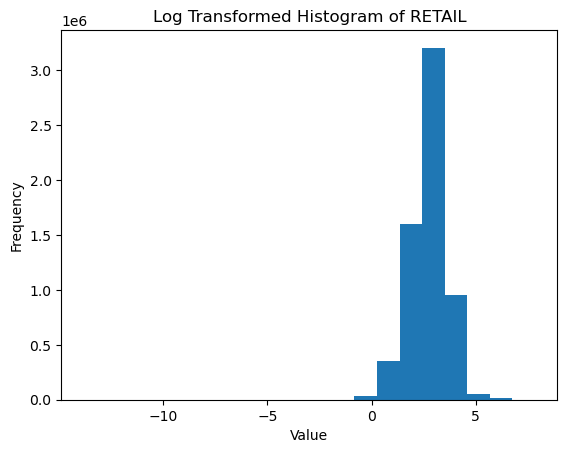

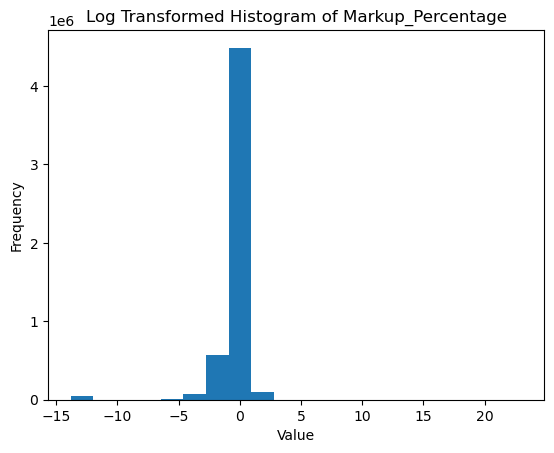

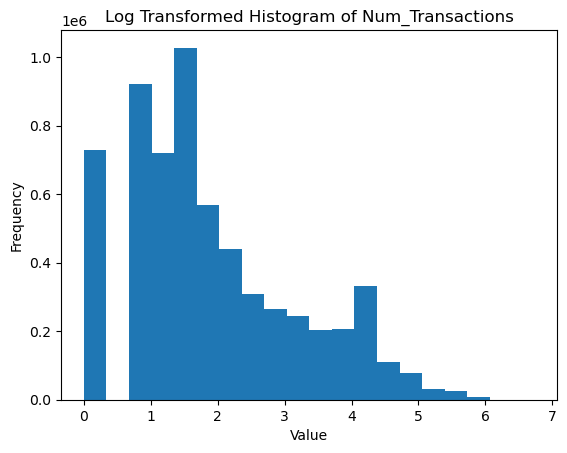

In [38]:
# Try log transformation of numerical columns
for column in numerical_df.columns:
    # Log transformation, adding a small value to avoid log(0)
    transformed = np.log(merged_df[column] + 1e-6)

    # Plotting
    plt.figure()
    plt.hist(transformed, bins=20)
    plt.title(f'Log Transformed Histogram of {column}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.show()

In [39]:
# See how many returned items there are in each SKU.
result = merged_df.groupby(['SKU', 'STYPE']).size().unstack(fill_value=0).reset_index()
result.rename(columns={'r': 'count_r', 'p': 'count_p'}, inplace=True)
# Seems like return rate doesnt have big concern with SKU
result

STYPE,SKU,P,R
0,1000196,75,6
1,1000331,145,15
2,1000394,1,0
3,1000421,4,0
4,1000497,2,0
...,...,...,...
107337,9999388,25,4
107338,9999683,79,2
107339,9999736,16,1
107340,9999764,63,0


In [40]:
# Correlation Analysis
# Create a binary column 'Has_Discount' to indicate the presence of a discount
merged_df['Has_Discount'] = merged_df['ORGPRICE'] != merged_df['SPRICE']

# Create a contingency table
contingency_table = pd.crosstab(merged_df['STYPE'], merged_df['Has_Discount'])

chi2, p, _, _ = chi2_contingency(contingency_table)
print(chi2, p)

# Result shows us there is a significant relationship between the type of transaction ('P' or 'R') and the presence of a discount.

197.09658373424378 8.983487497173448e-45


* Log transformation

In [41]:
merged_df.columns

Index(['SKU', 'STORE', 'TRANNUM', 'SALEDATE', 'QUANTITY', 'STYPE', 'ORGPRICE',
       'SPRICE', 'AMT', 'COST', 'RETAIL', 'DEPT', 'STYLE', 'COLOR', 'SIZE',
       'BRAND', 'year', 'month', 'day_of_week', 'day_of_month', 'quarter',
       'Markup_Percentage', 'Num_Transactions', 'Has_Discount'],
      dtype='object')

In [42]:
constant = 1e-6
merged_df['ORGPRICE'] = np.log(merged_df['ORGPRICE'] + constant)
merged_df['SPRICE'] = np.log(merged_df['SPRICE'] + constant)
merged_df['AMT'] = np.log(merged_df['AMT'] + constant)
merged_df['COST'] = np.log(merged_df['COST'] + constant)
merged_df['RETAIL'] = np.log(merged_df['RETAIL'] + constant)

* Prepare for training dataset

In [43]:
num_features = ['Markup_Percentage', 'Num_Transactions']
cat_features = ['year', 'month', 'day_of_week', 'day_of_month', 'quarter', 'Has_Discount', 'DEPT']

output = 'STYPE'

In [44]:
X = merged_df[num_features+cat_features]
y = merged_df[output]
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(), cat_features)
    ]
)

## Randomforest 

In [47]:
# Train a RandomForestClassifier model
# Set n_estimators = 5

classifier = RandomForestClassifier(n_estimators=5, verbose=2)

# Create the imblearn pipeline
pipeline = ImblearnPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('classifier', classifier)
])

pipeline.fit(X_train, y_train)

# And use it to make predictions
y_pred = pipeline.predict(X_test)

# Make predictions on the test set
# y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 5


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 16.3min remaining:    0.0s


building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 80.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.2s finished


Accuracy: 0.7967699551572396


In [45]:
# Set n_estimators = 10

classifier = RandomForestClassifier(n_estimators=10, verbose=2)

# Create the imblearn pipeline
pipeline = ImblearnPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('classifier', classifier)
])

pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 16.6min remaining:    0.0s


building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 166.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.8s finished


Accuracy: 0.7993818506409152


In [46]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred,average="binary", pos_label='P')
recall = recall_score(y_test, y_pred, average="binary", pos_label='P')
f1score = f1_score(y_test, y_pred,average="binary", pos_label='P')

print(f"Accuracy = {accuracy}")
print(f"Precision = {precision}")
print(f"Recall = {recall}")
print(f"F1 Score = {f1score}")

# Convert 'P' to 1 and 'R' to 0 in y_test and y_pred
y_test_num = np.where(y_test == 'P', 1, 0)
y_pred_num = np.where(y_pred == 'P', 1, 0)

# Making confusion matrix

conf_matrix = (y_test_num, y_pred_num)

conf_matrix

Accuracy = 0.7993818506409152
Precision = 0.9369829378743069
Recall = 0.8389752118884789
F1 Score = 0.8852747559890259


(array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 1, ..., 1, 0, 1]))

## LogisticRegression

In [45]:
# Train as Logistic Regression
classifier = LogisticRegression(random_state=42,max_iter=1000)

# Create the imblearn pipeline
pipeline = ImblearnPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('classifier', classifier)
])

pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

In [46]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred,average="binary", pos_label='P')
recall = recall_score(y_test, y_pred, average="binary", pos_label='P')
f1score = f1_score(y_test, y_pred,average="binary", pos_label='P')

print(f"Accuracy = {accuracy}")
print(f"Precision = {precision}")
print(f"Recall = {recall}")
print(f"F1 Score = {f1score}")

# Convert 'P' to 1 and 'R' to 0 in y_test and y_pred
y_test_num = np.where(y_test == 'P', 1, 0)
y_pred_num = np.where(y_pred == 'P', 1, 0)

# Making confusion matrix

conf_matrix = (y_test_num, y_pred_num)

conf_matrix

Accuracy = 0.5791630339455637
Precision = 0.9529057382621702
Recall = 0.5723912093496645
F1 Score = 0.7151851562728275


(array([1, 1, 1, ..., 1, 1, 1]), array([0, 1, 1, ..., 0, 1, 1]))

We got the highest accuracy using random forest model with n estimators = 10. Therefore, we choose to use this model as our final model.